In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn 
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2.1.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.2.1
numpy 1.18.2
sklearn 0.22.2.post1
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [3]:
# python 网页打开并保存
#https://storage.googleapis.com/tf-datasets/titanic/train.csv
#https://storage.googleapis.com/tf-datasets/titanic/eval.csv
#os.mkdir("./data")
from urllib import request
url = "https://storage.googleapis.com/tf-datasets/titanic/train.csv" #网页地址
wp = request.urlopen(url) #打开连接
content = wp.read() #获取页面内容
fp = open("./data/train.csv","w+b") #打开一个文本文件
fp.write(content) #写入数据
fp.close() #关闭文件

In [4]:
train_file="./data/train.csv"
eval_file="./data/eval.csv"

train_df=pd.read_csv(train_file)
eval_df=pd.read_csv(eval_file)

print(train_df.head())
print(eval_df.head())

   survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
   survived     sex   age  n_siblings_spouses  parch     fare   class  \
0         0    male  35.0                   0      0   8.0500   Third   
1         0    male  54.0                   0      0  51.8625   First   
2         1  female  58.0                   0      0  26.5500   First   
3         1  female  55.0                   0      0  16.0000  Second   
4         

In [5]:
y_train=train_df.pop('survived')
y_eval=eval_df.pop('survived')

print(train_df.head())
print(eval_df.head())
print(y_train.head())
print(y_eval.head())

      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
      sex   age  n_siblings_spouses  parch     fare   class     deck  \
0    male  35.0                   0      0   8.0500   Third  unknown   
1    male  54.0                   0      0  51.8625   First        E   
2  female  58.0                   0      0  26.5500   First        C   
3  female  55.0                   0      0  16.0000  Second  unknown   
4    male  34.0                   0      0  13.0000  Second        D   

  

In [6]:
train_df.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [7]:
print(train_df.shape,eval_df.shape)

(627, 9) (264, 9)


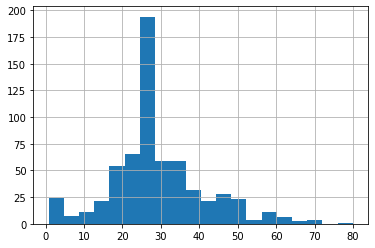

In [8]:
train_df.age.hist(bins=20)

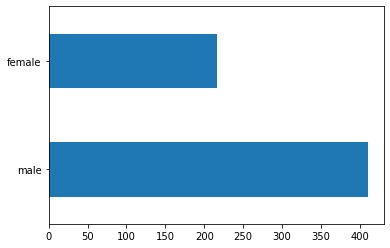

In [9]:
train_df.sex.value_counts().plot(kind='barh')#barv 纵向

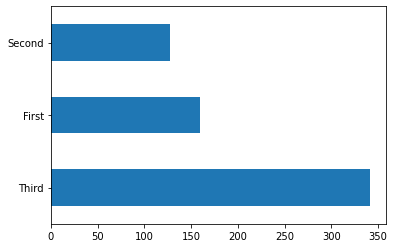

In [10]:
train_df['class'].value_counts().plot(kind='barh')

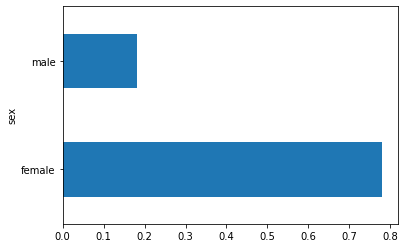

In [11]:
pd.concat([train_df,y_train],axis=1).groupby('sex').survived.mean().plot(kind='barh')

In [18]:
categorical_columns=['sex','n_siblings_spouses','parch','class','deck','embark_town','alone']
numeric_columns=['age','fare']

feature_columns=[]
for categorical_column in categorical_columns:
    vocab=train_df[categorical_column].unique()
    print(categorical_column,vocab)
    feature_columns.append(
        tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_vocabulary_list(categorical_column,vocab)))

for categorical_column in numeric_columns:
    feature_columns.append(
        tf.feature_column.numeric_column(
            categorical_column,dtype=tf.float32))

sex ['male' 'female']
n_siblings_spouses [1 0 3 4 2 5 8]
parch [0 1 2 5 3 4]
class ['Third' 'First' 'Second']
deck ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone ['n' 'y']


In [26]:
def make_dataset(data_df,label_df,epochs=10,shuffle=True,bs=32):
    dataset=tf.data.Dataset.from_tensor_slices((dict(data_df),label_df))
    if shuffle:
        dataset=dataset.shuffle(10000)
    dataset=dataset.repeat(epochs).batch(bs)
    return dataset

In [23]:
dict(train_df)

{'sex': 0        male
 1      female
 2      female
 3      female
 4        male
         ...  
 622      male
 623      male
 624    female
 625    female
 626      male
 Name: sex, Length: 627, dtype: object,
 'age': 0      22.0
 1      38.0
 2      26.0
 3      35.0
 4      28.0
        ... 
 622    28.0
 623    25.0
 624    19.0
 625    28.0
 626    32.0
 Name: age, Length: 627, dtype: float64,
 'n_siblings_spouses': 0      1
 1      1
 2      0
 3      1
 4      0
       ..
 622    0
 623    0
 624    0
 625    1
 626    0
 Name: n_siblings_spouses, Length: 627, dtype: int64,
 'parch': 0      0
 1      0
 2      0
 3      0
 4      0
       ..
 622    0
 623    0
 624    0
 625    2
 626    0
 Name: parch, Length: 627, dtype: int64,
 'fare': 0       7.2500
 1      71.2833
 2       7.9250
 3      53.1000
 4       8.4583
         ...   
 622    10.5000
 623     7.0500
 624    30.0000
 625    23.4500
 626     7.7500
 Name: fare, Length: 627, dtype: float64,
 'class': 0       Third
 

In [27]:
train_dataset=make_dataset(train_df,y_train,bs=5)

In [29]:
for x,y in train_dataset.take(1):
    print(x,y)

{'sex': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'male', b'male', b'male', b'male', b'male'], dtype=object)>, 'age': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([28.,  2., 18., 28., 17.])>, 'n_siblings_spouses': <tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 4, 0, 0, 0], dtype=int32)>, 'parch': <tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 1, 0, 0, 0], dtype=int32)>, 'fare': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([30.5   , 39.6875,  8.3   ,  7.775 ,  8.6625])>, 'class': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'First', b'Third', b'Third', b'Third', b'Third'], dtype=object)>, 'deck': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'C', b'unknown', b'unknown', b'unknown', b'unknown'], dtype=object)>, 'embark_town': <tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'Southampton', b'Southampton', b'Southampton', b'Southampton',
       b'Southampton'], dtype=object)>, 'alone': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'y

In [31]:
# keras.layers.DenseFeature

for x,y in train_dataset.take(1):
    age_column=feature_columns[7]
    gender_column=feature_columns[0]
    print(keras.layers.DenseFeatures(age_column)(x).numpy())
    print(keras.layers.DenseFeatures(gender_column)(x).numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[35.]
 [28.]
 [28.]
 [28.]
 [28.]]

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base 

In [33]:
# keras.layers.DenseFeature

for x,y in train_dataset.take(1):
    age_column=feature_columns[7]
    gender_column=feature_columns[0]
    print(keras.layers.DenseFeatures(feature_columns)(x).numpy())



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[34.      0.      1.      0.      1.      0.      1.      0.      0.
   0.      0.      0.      0.      0.      1.      0.      0.      0.
  26.55    0.      1.      0.      0.      0.      0.      0.      1.
   0.      0.      0.      0.      0.      1.      0.    ]
 [28.      0.      1.      1.      0.      0.      1.      0.      0.
   0.      0.      0.      0.      0.      1.      0.      0.      0.
   7.8958  0.      1.      0.      0.      0.      0.      0.      1.
   0.      0.      0.      0.

In [36]:
model =keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100,activation='relu'),
    keras.layers.Dense(100,activation='relu'),
    keras.layers.Dense(2,activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.SGD(lr=0.01),
             metrics=['accuracy'])

In [38]:
#1. model.fit
#2. model->estimator->train

train_dataset=make_dataset(train_df,y_train,epochs=100)
eval_dataset=make_dataset(eval_df,y_eval,epochs=1,shuffle=False)
history=model.fit(train_dataset,
                 validation_data=eval_dataset,
                 steps_per_epoch=20,
                 validation_steps=8,
                 epochs=100)

Train for 20 steps, validate for 8 steps
Epoch 1/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4951 - accuracy: 0.7797 - val_loss: 0.5360 - val_accuracy: 0.7266
Epoch 2/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5419 - accuracy: 0.7391 - val_loss: 0.4961 - val_accuracy: 0.7539
Epoch 3/100
20/20 [==============================] - 0s 3ms/step - loss: 0.4873 - accuracy: 0.7672 - val_loss: 0.5052 - val_accuracy: 0.7500
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5161 - accuracy: 0.7609 - val_loss: 0.4914 - val_accuracy: 0.7539
Epoch 5/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5142 - accuracy: 0.7719 - val_loss: 0.5213 - val_accuracy: 0.7500
Epoch 6/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5147 - accuracy: 0.7547 - val_loss: 0.5919 - val_accuracy: 0.7227
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5723 - accuracy: 0.7219 - val_loss: 0.

20/20 [==============================] - 0s 3ms/step - loss: 0.4924 - accuracy: 0.7766 - val_loss: 0.4934 - val_accuracy: 0.7617
Epoch 59/100
20/20 [==============================] - 0s 3ms/step - loss: 0.4854 - accuracy: 0.7828 - val_loss: 0.5908 - val_accuracy: 0.7148
Epoch 60/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5329 - accuracy: 0.7641 - val_loss: 0.4870 - val_accuracy: 0.7617
Epoch 61/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5026 - accuracy: 0.7516 - val_loss: 0.4900 - val_accuracy: 0.7617
Epoch 62/100
20/20 [==============================] - 0s 3ms/step - loss: 0.4992 - accuracy: 0.7828 - val_loss: 0.4971 - val_accuracy: 0.7578
Epoch 63/100
20/20 [==============================] - 0s 3ms/step - loss: 0.4772 - accuracy: 0.7953 - val_loss: 0.4816 - val_accuracy: 0.7656
Epoch 64/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5137 - accuracy: 0.7547 - val_loss: 0.4973 - val_accuracy: 0.7656
Epoch 65/100
20/20 

ValueError: Empty training data.

In [41]:
estimator=keras.estimator.model_to_estimator(model)
#1. function
#2.return a. (featrues,labels) b.dataset->(feature,label)

estimator.train(input_fn= lambda: make_dataset(train_df,y_train,epochs=100))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpiw3c4e9o', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas':

ValueError: Unexpectedly found an instance of type `<class 'dict'>`. Expected a symbolic tensor instance.